In [70]:
import cartopy.crs as ccrs
from contourpy import contour_generator
from geocube.vector import vectorize
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
import numpy as np
import pystac_client
import planetary_computer
import rioxarray as rio
from shapely.geometry import shape
from shapely import LineString, box
import xarray as xr
from xrspatial.classify import natural_breaks, equal_interval
from xrspatial import hillshade

plt.rcParams['font.family'] = 'DejaVu Sans Mono'

In [2]:
aoi_geom = shape({
      "coordinates": [[
            [-0.08985080593200223,50.858667861221164],
            [-0.08985080593200223,50.79414350067211],
            [0.007405918192461058,50.79414350067211],
            [0.007405918192461058,50.858667861221164],
            [-0.08985080593200223,50.858667861221164]]],
      "type": "Polygon"})

aoi = gpd.GeoDataFrame(geometry=[aoi_geom], crs=4326)
prj = ccrs.epsg(aoi.estimate_utm_crs().to_epsg())

In [3]:
## get contours in aoi from copernicus global DEM hosted on planetary computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(collections=['cop-dem-glo-30'],
                        intersects=aoi_geom.envelope)
items = list(search.get_items())

# if aoi crosses multiple DEM tiles stitch 'em together
if len(items) > 1:
    data = []
    for item in items:
        signed_asset = planetary_computer.sign(item.assets["data"])
        with rio.open_rasterio(signed_asset.href) as f:
            data.append(f.squeeze().drop_vars("band").rename('z'))
    dem = ((xr.merge(data))
           .rio.set_crs(4326)
           .rio.write_transform()
           .rio.clip_box(*aoi_geom.bounds))['z']
    f.close()
else:
    signed_asset = planetary_computer.sign(items[0].assets["data"])
    dem =  (rio.open_rasterio(signed_asset.href)
            .squeeze()
            .rio.set_crs(4326)
            .rio.write_transform()
            .rio.clip_box(*aoi_geom.bounds)).rename('z')

c:\Users\s1759665\Miniconda3\envs\xdem_plancomp\lib\site-packages\pystac_client\item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


In [132]:
 # reproject to local utm crs
dem_prj = dem.rio.reproject(prj, resolution=30, nodata=np.nan)

# fix wonky
x,y=aoi.to_crs(prj)['geometry'][0].exterior.coords.xy
sortx = np.sort(x)
sorty = np.sort(y)
minx, maxx=sortx[np.diff(sortx).argmax():np.diff(sortx).argmax()+2] ######## fiddly!
miny, maxy=sorty[np.diff(sorty).argmax():np.diff(sorty).argmax()+2]
dem_prj = dem_prj.rio.clip_box(minx,miny,maxx,maxy)
hs = hillshade(dem_prj, azimuth=0)

## for correctly making title coordinates
p = gpd.GeoSeries(box(*dem_prj.rio.bounds()),
              crs=prj).centroid.to_crs(4326)[0]

if p.y < 0:
    Y = p.y * -1
    ns = 'S'
else:
    Y = p.y
    ns = 'N'
    
if p.x < 0:
    X = p.x * -1
    ew = 'W'
else:
    X = p.x
    ew = 'E'
    
title_coords = f'{Y:.2f}° {ns}, {X:.2f}° {ew}'

### getting natural breaks

In [120]:
# get reclassify raster using natural breaks and reclassify
method = 'equal_interval'
k = 10

if method == 'equal_interval':
    classif = equal_interval(dem_prj, k=k)
elif method == 'natural_breaks':
    classif = natural_breaks(dem_prj, k=k)
    
polys = vectorize(classif)

# make hatch codes
dotty = dict(zip(range(k),['.'*i for i in range(k)]))
polys['dotty'] = polys[method].map(dotty)

## because xrspatial.classify.natural_breaks just reclassifies and doesn't reveal where the breaks are...
break_dict = {}
for n in np.unique(classif.data):
    _min = xr.where(classif==n, dem_prj, np.nan).min().item()
    _max = xr.where(classif==n, dem_prj, np.nan).max().item()
    break_dict[n] = (_min,_max)

breaks = [break_dict[0][0]] + [b[1] for b in break_dict.values()]

### for tanaka
[this](https://anitagraser.com/2015/05/24/how-to-create-illuminated-contours-tanaka-style/) blogpost by Anita Graser was helpful

In [130]:

# contour generator
cg = contour_generator(x=dem_prj.x.values,
                       y=dem_prj.y.values,
                       z=dem_prj.data)

# get each contour line for each break
lines = []
for b in breaks:
    lines += [LineString(l) for l in cg.lines(b)]

# for each individual line, split contour at every node and determine azimuth
# and from azzimuth define line width 
# from contourpy docs:
        # Contour line segments are directed with higher z on the left, 
        # hence closed line loops are oriented anticlockwise if they enclose
        # a region that is higher then the contour level, or clockwise if they
        # enclose a region that is lower than the contour level.
        # This assumes a right-hand coordinate system.
# i *think* this means my azimuth calcs are okay
segments = []
azimuths = []
widths = []
for l in lines:
    for p1,p2 in zip(l.coords, l.coords[1:]):
        segments.append(LineString([p1,p2]))
        xy_diff = np.array([p2[0]-p1[0],
                            p2[1]-p1[1]])
        azi = np.rad2deg(np.arctan2(xy_diff[1],
                                    xy_diff[0])) - 60 # for having light source coming from NW
        if azi < 0:
            azi += 360
        azimuths.append(azi)
        widths.append(0.05+np.abs(np.cos(np.deg2rad(azi)))) # vary line widths

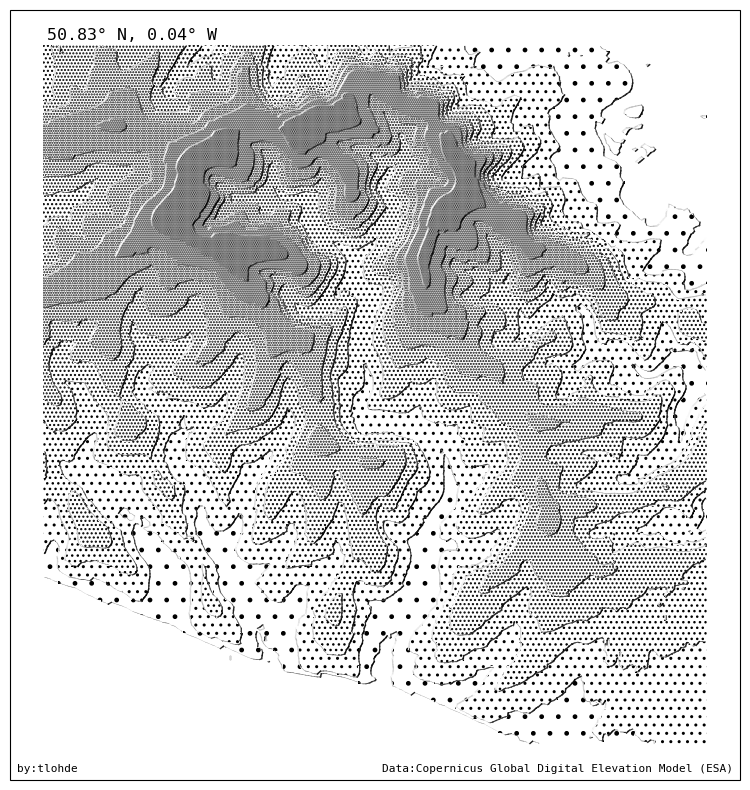

In [133]:
fig, ax = plt.subplots(figsize=[10,10],
                       subplot_kw={'projection':prj})

# cmap = plt.get_cmap('magma')
# norm = Normalize(0,7)
for b in np.unique(polys[method]):  
    a = (polys.loc[polys[method].eq(b)].plot(fc='none',
                                            #  edgecolor=cmap(norm(b)),
                                             ec='k',
                                             hatch=dotty[b],
                                             linewidth=0,
                                             label=np.round(b),
                                             ax=ax))

cmap = LinearSegmentedColormap.from_list('kwk', ['w','k','w'])
norm = Normalize(0,360)
_ = [ax.plot(*l.coords.xy,
             c=cmap(norm(c)),
            #  alpha = w-0.05,
             linewidth=w) for l,c,w in zip(segments,azimuths,widths)]
 
ax.set_title(title_coords,y=0.95,x=0.05, ha='left')

ax.annotate(text='Data:Copernicus Global Digital Elevation Model (ESA)',
            xy=(0.99,0.01), 
            xycoords='axes fraction', 
            ha='right', 
            fontsize=8)

ax.annotate(text='by:tlohde',
            xy=(0.01,0.01), 
            xycoords='axes fraction',
            ha='left',
            fontsize=8)

fig.savefig('day27.png', dpi=300, bbox_inches='tight')

CRS.from_epsg(32630)